<a href="https://colab.research.google.com/github/fragmento/Mod_4_-Andres_Mendel/blob/master/Notebooks/Xception_model_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with Chest x rays to identify Pneumonia

For this exercice we will be working with a dataset uploaded from Kaggle (https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

Let's explore the data.

In [1]:
#Basic uploads
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread #to read image from

import seaborn as sns
import os

%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jun 18 11:17:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    36W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path_to_data = '/content/drive/My Drive/Colab Notebooks/Mod_4_Andres_Mendel/Data/chest_xray'

# Xception model Transfer learning 

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [7]:
from sklearn.metrics import classification_report, confusion_matrix

## Pretrained Xception Model


The Xception Model is a variant of the GoogLeNet architecture is worth noting: Xception 19 (which stands for Extreme Inception ) was proposed in 2016 by François Chollet (the author of Keras), and it significantly outperformed Inception-v3 on a huge vision task (350 million images and 17,000 classes). Just like Inception-v4, it merges the ideas of GoogLeNet and ResNet, but it replaces the inception modules with a special type of layer called a depthwise separable convolution layer (or separable convolution layer for short 20 ). 


In [8]:
batch_size = 64
target_shape = (224,224)


# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        path_to_data+'/train',  # this is the target directory
        target_size=target_shape,  # all images will be resized to 224x224
        batch_size=batch_size,
        # since we use binary_crossentropy loss, we need binary labels
        class_mode='binary') 

# this is a similar generator, for validation data

validation_generator = test_datagen.flow_from_directory( 
        path_to_data+'/test',
        target_size=target_shape,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [10]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(1, activation="sigmoid")(avg) #2 number of classes
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [12]:
for layer in base_model.layers:
    layer.trainable = False

#optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_x = model.fit(
        train_generator,
        epochs=5,
        steps_per_epoch=int(0.75 * 5016 / batch_size),
        validation_data=validation_generator,
        validation_steps=int(0.75 * 624 / batch_size),
        verbose =1,
        workers = -1,
        )

Epoch 1/5
58/58 [==============================] - 97s 2s/step - loss: 0.3140 - accuracy: 0.8682 - val_loss: 0.5284 - val_accuracy: 0.7500
Epoch 2/5
58/58 [==============================] - 95s 2s/step - loss: 0.2038 - accuracy: 0.9234 - val_loss: 0.4736 - val_accuracy: 0.7991
Epoch 3/5
58/58 [==============================] - 95s 2s/step - loss: 0.1829 - accuracy: 0.9359 - val_loss: 0.4048 - val_accuracy: 0.8237
Epoch 4/5
58/58 [==============================] - 96s 2s/step - loss: 0.1782 - accuracy: 0.9353 - val_loss: 0.3871 - val_accuracy: 0.8415
Epoch 5/5
58/58 [==============================] - 95s 2s/step - loss: 0.1647 - accuracy: 0.9389 - val_loss: 0.4186 - val_accuracy: 0.8259


In [13]:
for layer in base_model.layers:
  layer.trainable = True

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_x_2= model.fit(
        train_generator,
        epochs=2,
        steps_per_epoch=int(0.75 * 5016 / batch_size),
        validation_data=validation_generator,
        validation_steps=int(0.75 * 624 / batch_size),
        verbose =1,
        workers = -1,
        )
model.save_weights('Xception_weights_1.h5')  # always save your weights after training or during training
model.save('Xception_try_1.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
58/58 [==============================] - 129s 2s/step - loss: 0.1391 - accuracy: 0.9494 - val_loss: 1.3136 - val_accuracy: 0.8683
Epoch 2/2
58/58 [==============================] - 128s 2s/step - loss: 0.0837 - accuracy: 0.9693 - val_loss: 0.2471 - val_accuracy: 0.9219


In [14]:
history_1 = pd.DataFrame(history_x.history)
history_2 = pd.DataFrame(history_x_2.history)


In [15]:
#joining both histories (frozen and unfrozen)
history_join = pd.concat([history_1,history_2]).reset_index(drop=True)

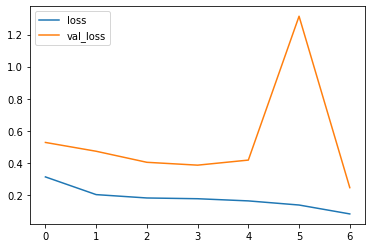

In [16]:
history_join[['loss', 'val_loss']].plot();

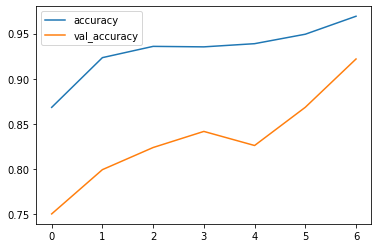

In [17]:
history_join[['accuracy', 'val_accuracy']].plot();

In [18]:
model.evaluate(validation_generator)

10/10 [==============================] - 6s 601ms/step - loss: 0.3070 - accuracy: 0.9135


[0.30695098638534546, 0.9134615659713745]

sesion crash reconstructing the model:

In [19]:
#reconstructed model from earlier execution
#reconstructed_model = keras.models.load_model("/content/Xception_try_1.h5")
#reconstructed_model.evaluate(validation_generator)

In [20]:
#testing the 624 images
#We first noremalize and then reshape the images to the approtiate (224,224)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory( 
        path_to_data+'/test',
        target_size=(224,224),
        class_mode='binary',
        shuffle=False )

Found 624 images belonging to 2 classes.


In [21]:
pred_prob = model.predict(test_generator)
#pred_prob

In [22]:
prediction = pred_prob >0.5
#prediction

In [23]:
print(classification_report(test_generator.classes,prediction))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       234
           1       0.93      0.93      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.91      0.91       624
weighted avg       0.91      0.91      0.91       624



In [24]:
print(confusion_matrix(validation_generator.classes,prediction))

[[207  27]
 [ 27 363]]


### Testing on 16 Unseen images

In [25]:
#test set 16 images
#We first noremalize and then reshape the images to the approtiate (224,224)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory( 
        path_to_data+'/val',
        target_size=target_shape,
        class_mode='binary',
        shuffle=False )

Found 16 images belonging to 2 classes.


In [26]:
# geting the probalilites of the 0 == Normal 1==Pneumonia
test_prob = model.predict(test_generator)
test_prob

array([[4.6171024e-02],
       [9.0186910e-07],
       [3.3814923e-03],
       [3.4995392e-06],
       [2.2490139e-01],
       [4.6543914e-01],
       [6.5033902e-07],
       [1.1471725e-08],
       [9.9929905e-01],
       [9.9619919e-01],
       [9.5784706e-01],
       [2.3471229e-01],
       [9.0720707e-01],
       [9.9979085e-01],
       [9.9819249e-01],
       [8.4422797e-01]], dtype=float32)

In [27]:
# seting a booundary for the prediction False == 0 == Normal True == 1 == Pneumonia
test_predic = test_prob >.5

In [28]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [29]:
print(classification_report(test_generator.classes,test_predic))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



In [30]:
print(confusion_matrix(test_generator.classes,test_predic))

[[8 0]
 [1 7]]
